# 用神经网络的方法实现Logistic Regression

【声明】本notebook再现Coursera Deep Learning课程C1W1作业，仅供个人学习使用，请勿用于商业用途。


## 1 - Packages ##

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image # 图像显示
from scipy import  ndimage


/Users/pengju/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
def load_dataset():
    #  读入h5文件的函数,生成 train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes
    train_dataset=h5py.File("./datasets/train_catvnoncat.h5",'r')
    train_set_x_orig= np.array(train_dataset['train_set_x'][:])
    train_set_y_orig= np.array(train_dataset['train_set_y'][:])
    classes=np.array(train_dataset['list_classes'][:])

    test_dataset=h5py.File("./datasets/test_catvnoncat.h5",'r')
    test_set_x_orig= np.array(test_dataset['test_set_x'][:])
    test_set_y_orig= np.array(test_dataset['test_set_y'][:])

    train_set_y_orig=train_set_y_orig.reshape(1,-1)
    test_set_y_orig=test_set_y_orig.reshape(1,-1)
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

## 2 探索数据集

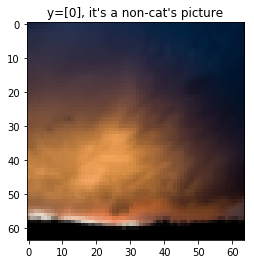

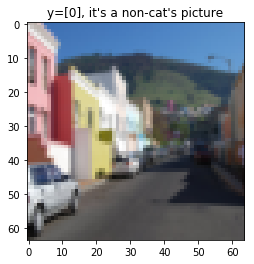

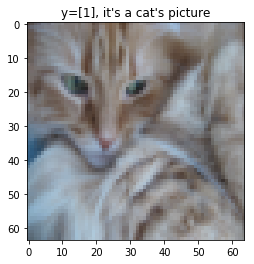

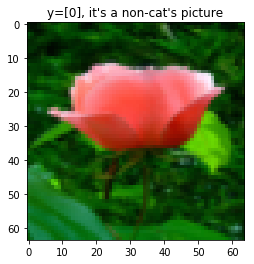

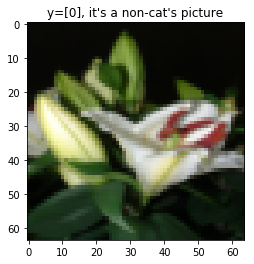

In [4]:
# 加载数据
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes=load_dataset()
# 查看一张图片
for idx in range(5):
    plt.imshow(train_set_x_orig[idx])
    plt.title("y={}, it's a {}'s picture".format(
        str(train_set_y[:,idx]),(classes[np.squeeze(train_set_y[:,idx])]).decode('utf-8')))
    plt.show()


In [5]:
m_train=train_set_x_orig.shape[0]
m_test=test_set_x_orig.shape[0]
num_px=train_set_x_orig.shape[1]

print("training ssample number={}, positive samle={}".format(m_train,np.squeeze(train_set_y).sum()))
print("test ssample number={}".format(m_test))
print("px in w/h={}".format(num_px))
print("each image size= {}*{}*{}".format(train_set_x_orig.shape[1],train_set_x_orig.shape[2],train_set_x_orig.shape[3]))
print("train_set_x_orig shape={}".format(train_set_x_orig.shape))
print("test_set_x_orig shape={}".format(test_set_x_orig.shape))
print("train_set_y shape={}".format(train_set_y.shape))
print("test_set_y shape={}".format(test_set_y.shape))


training ssample number=209, positive samle=72
test ssample number=50
px in w/h=64
each image size= 64*64*3
train_set_x_orig shape=(209, 64, 64, 3)
test_set_x_orig shape=(50, 64, 64, 3)
train_set_y shape=(1, 209)
test_set_y shape=(1, 50)


In [6]:
# 为了在神经网络中输入数据时，单个图片形状应从 (num_px,num_px,3)转换为(num_px*num_px*3,1)
train_set_x_flatten=train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten=test_set_x_orig.reshape(test_set_x_orig.shape[0],-1).T

print("train_set_x_flatten shape={}".format(train_set_x_flatten.shape))
print("train_set_y shape={}".format(train_set_y.shape))
print("test_set_x_flatten shape={}".format(test_set_x_flatten.shape))
print("test_set_y shape={}".format(test_set_y.shape))
print("check  {}".format(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape=(12288, 209)
train_set_y shape=(1, 209)
test_set_x_flatten shape=(12288, 50)
test_set_y shape=(1, 50)
check  [17 31 56 22 33]


In [7]:
# 图像数据归一化：简化版除以 255
train_set_x=train_set_x_flatten/255
test_set_x=test_set_x_flatten/255


## 3 学习方法的通用架构(拍照写清楚)

**Logistic Regression 是非常简单的神经网络**

- 示意图说明 &正向传播公式 & 反向传播公式
<img src="my_file/LR_forward_backword_propagation.jpg" style="width:650px;height:900px;">



## 4 程序架构（模块分解及功能）

- 完成作业过程中，按照已有的架构，填补空缺的难度，是非常低的；但是这种成长也是非常有限的
- 有价值的成长过程应包含（1）理解思路（2）拆解模块（3）再现（4）对比并总结

- 遇到问题1：
    - 描述：输入全量数据运行optimize时没有梯度下降
```
{0: 0.6,
 1: 10.5,
 2: nan,
 3: 31.5,
 4: 6.12,
 5: nan,
 6: 27.1,
 7: 1.78,
 8: nan,
 9: 24.2}
```
    - 思路（1）验算propagate和optimize的单步是否正确 【总结】 每个函数都要进行给个简单例子进行单例测试，形成方法论；除了验证结果正确性以外，还方便进行debug，否则所有训练集全部载入，很难debug的。  【验算结果】没有问题
    - 思路(2)<span style="color:red;font-weight:bold"> 问题出现在什么地方呢？ learning_rate 设置太大</span>  设置到0.005就可以了
    
- 编程技巧总结
    - 入参习惯：参数(w,b)、输入/输出值(X,Y)，调节系数(learning_rate,num_iterations)
    - 相同参数放到dict中
    
```
    grads = {"dw": dw,
         "db": db}
```
    
- 编程过程复盘：
    - 逻辑清晰很重要：结构属于 model中顺序结构（初始化、优化过程，输出预测值）；其中，优化过程是一个循环过程（子循环是 正- 常传播和反向传播并更新w，b）
    - 要有单元测试的概念
                

0.5
0.7310585786300049
sigmoid([0, 2]) = [0.5        0.88079708]


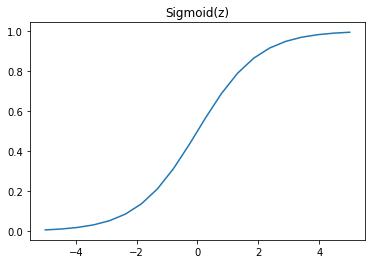

In [8]:
def sigmoid(z):
    """
    计算Sigmoid 函数
    Parameters
    ----------
    z : 标量或者任意形状数组

    Returns
    -------
    s : sigmod(z)

    """
    s=1.0/(1.0+np.exp(-z))
    return s

z=np.linspace(-5,5,20)
%matplotlib inline
s=sigmoid(z)

plt.plot(z,s)
plt.title("Sigmoid(z)")

print(sigmoid(0))
print(sigmoid(1))

print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

In [9]:
def initialize_with_zeros(dim):
    """
    初始化w（维度为(dim,1)）和b(标量)，值全为0
    

    Parameters
    ----------
    dim : w向量的维度

    Returns
    -------
    w : (dim,1)
    b : 偏置项 标量
    """
    w=np.zeros(shape=(dim,1))
    b=0
    return w,b

w,b=initialize_with_zeros(train_set_x.shape[0])
print("w.shape={}".format(w.shape))
print("b={}".format(b))


dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w.shape=(12288, 1)
b=0
w = [[0.]
 [0.]]
b = 0


In [10]:
def propagate(w,b,X,Y):
    """
    正向传播与反向反向传播，并计算损失函数
    

    Parameters
    ----------
    w :  权重，维度= (num_px*num*px*3,1)
    b : 偏置项，标量
    X : 输入数据，维度=(num_px*num*px*3,num of samples)
    Y : 输入数据所对应的真实标签 取值(0 非猫 1 猫) 维度=(1,num of samples)

    Returns
    -------
    cost : 损失函数， 负对数似然损失
    dw : cost 对应 w的梯度，与w维度一样
    db : cost 对应 b的梯度，与b维度一样       
    """
    
    dim,m=X.shape
    # 正向传播     
    A=sigmoid(np.matmul(w.T,X)+b)
    cost=-np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))/m
    # 反向传播
    dw=np.matmul(X,(A-Y).T)/m
    db=np.sum(A-Y)/m
    grads = {"dw": dw,
             "db": db}
    return grads, cost

# 验证结果的正确性
w=np.array([[0.1],[0.2],[0.3]])
print('w=\n',w)
X=np.array([[1,2],[3,4],[5,6]])
print('X=\n',X)
Z=np.matmul(w.T,X)
print("Z=",Z)
A=sigmoid(Z)
print("A=",A)
Y=np.array([[0.4,0.7]])
num_dim,m=X.shape
cost=-np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))/m
print("cost=",cost)



w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

w=
 [[0.1]
 [0.2]
 [0.3]]
X=
 [[1 2]
 [3 4]
 [5 6]]
Z= [[2.2 2.8]]
A= [[0.90024951 0.94267582]]
cost= 1.1620580730283336
dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


In [11]:
def optimize(w,b,X,Y,learning_rate,num_iterations,print_cost=False):
    """
    通过梯度下降方法优化w和b
    

    Parameters
    ----------
    w :  权重，维度= (num_px*num*px*3,1)
    b : 偏置项，标量
    X : 输入数据，维度=(num_px*num*px*3,num of samples)
    Y : 输入数据所对应的真实标签 取值(0 非猫 1 猫) 维度=(1,num of samples)
    learning_rate : 学习率
    num_iterations: 循环次数
    print_cost: 打印损失每100loop


    Returns
    -------
    params:  w 和 b的 dict
    grads: dw和db的 dict
    costs: cost组成的list 
    """

    costs=[]
    for i in range(num_iterations):
        # 计算梯度和损失函数         
        grads,cost=propagate(w,b,X,Y)
        # 更新w， b        
        dw=grads['dw']
        db=grads['db']
        w=w-learning_rate*dw
        b=b-learning_rate*db
        if i%100==0:
            costs.append(cost)
        if (i%100==0) and (print_cost):
            print("cost after {} iterations, cost={}".format(i,cost))
            
    params={'w':w,'b':b}
    grads = {"dw": dw,
             "db": db}
    return params,grads,costs
        
    


params, grads, costs = optimize(w, b, X, Y, num_iterations= 100, learning_rate = 0.009,print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


In [12]:
def predict(w,b,X):
    """
    通过训练好的参数w和b，预测输入的X是0还是1
    

    Parameters
    ----------
    w :  权重，维度= (num_px*num*px*3,1)
    b : 偏置项，标量
    X : 输入数据，维度=(num_px*num*px*3,num of samples)


    Returns
    -------
    Y_prediction: 输入数据所对应的预测标签 取值(0 非猫 1 猫) 维度=(1,num of samples)

    Notes:
    -------
    score : 
    
            
    """
    dim,m=X.shape    
    A=sigmoid(np.matmul(w.T,X)+b)
    Y_prediction=(A>0.5).astype(int)
    assert (Y_prediction.shape==(1,m))
    return (Y_prediction)
    

In [13]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


In [14]:
# 验算结果
print(0.1124579*1+0.23106775*1.2-0.3)
print(0.1124579*(-1.1)+0.23106775*(2)-0.3)
print(0.1124579*(-3.2)+0.23106775*0.1-0.3)

0.08973919999999996
0.03843181000000001
-0.636758505


In [15]:
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    构建Logistic Regression 模型
    

    Parameters
    ----------
    X_train : 输入数据，维度=(num_px*num*px*3,num of train samples)
    Y_train : 输入数据所对应的真实标签 取值(0 非猫 1 猫) 维度=(1,num of train  samples)
    X_test : 输入数据，维度=(num_px*num*px*3,num of test samples)
    Y_test : 输入数据所对应的真实标签 取值(0 非猫 1 猫) 维度=(1,num of test samples)
    learning_rate : 学习率
    num_iterations: 循环次数
    print_cost: 打印损失每100loop
    
    
    Returns
    -------
    d : 输出结果

    Notes:
    -------
    score : 
    
            
    """
    #  参数 w,b初始化
    dim,m=X_train.shape
    w,b=initialize_with_zeros(dim=dim)
    
    # 梯度下降优化
    params, grads,costs= optimize(w,b,X_train,Y_train,learning_rate=learning_rate,num_iterations=num_iterations,print_cost=True)
    
    # 预测结果
    w=params['w']
    b=params['b']
    
    Y_prediction_train=predict(w,b,X_train)
    Y_prediction_test=predict(w,b,X_test)
    accuracy_train=1-np.mean(np.abs(Y_train-Y_prediction_train))
    accuracy_test=1-np.mean(np.abs(Y_test-Y_prediction_test))
    
    print("train accuray={:,.2%}".format(accuracy_train))
    print("test accuray={:,.2%}".format(accuracy_test))
    d={
        "costs":costs,
       "Y_prediction_train":Y_prediction_train,
       "Y_prediction_test":Y_prediction_test,
        'w':w,
        'b':b,
        'learning_rate':learning_rate,
        'num_iterations':num_iterations
    }
    return d



In [16]:
d=model(train_set_x,train_set_y,test_set_x,test_set_y,num_iterations=2000,learning_rate=0.005,print_cost=True)

cost after 0 iterations, cost=0.6931471805599453
cost after 100 iterations, cost=0.5845083636993086
cost after 200 iterations, cost=0.46694904094655476
cost after 300 iterations, cost=0.37600686694802093
cost after 400 iterations, cost=0.33146328932825125
cost after 500 iterations, cost=0.30327306747438293
cost after 600 iterations, cost=0.27987958658260487
cost after 700 iterations, cost=0.2600421369258757
cost after 800 iterations, cost=0.2429406846779662
cost after 900 iterations, cost=0.2280042225672606
cost after 1000 iterations, cost=0.2148195137844964
cost after 1100 iterations, cost=0.2030781906064499
cost after 1200 iterations, cost=0.19254427716706862
cost after 1300 iterations, cost=0.183033337968835
cost after 1400 iterations, cost=0.17439859438448874
cost after 1500 iterations, cost=0.1665213970540033
cost after 1600 iterations, cost=0.15930451829756614
cost after 1700 iterations, cost=0.15266732471296504
cost after 1800 iterations, cost=0.14654223503982342
cost after 1900

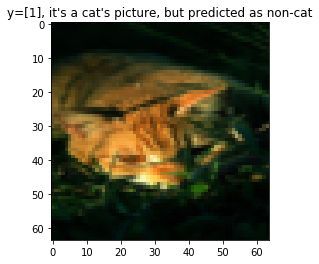

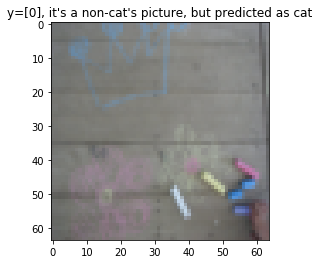

In [17]:
Y_prediction_train=d['Y_prediction_train']
Y_prediction_test=d['Y_prediction_test']
# 找到所有的错误标记的图片（预测集和验证集）
idx_wrong_label=np.where(np.squeeze(np.abs(Y_prediction_train-train_set_y)))[0]
for idx in idx_wrong_label:
    plt.imshow(train_set_x_orig[idx])
    plt.title(label="y={}, it's a {}'s picture, but predicted as {}".format(
        str(train_set_y[:,idx]),
        (classes[np.squeeze(train_set_y[:,idx])]).decode('utf-8'),
        (classes[np.squeeze(Y_prediction_train[:,idx])]).decode('utf-8')))
    plt.show()


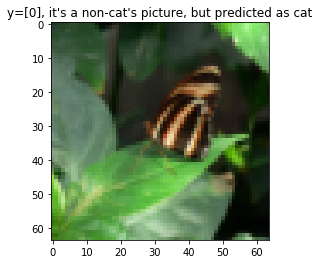

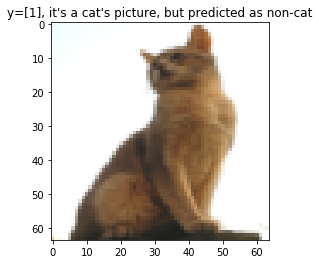

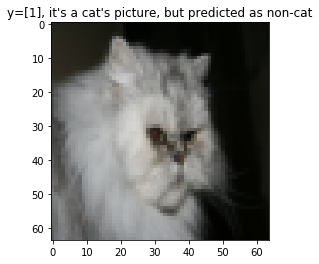

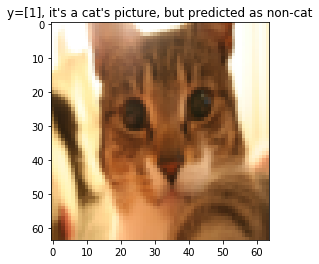

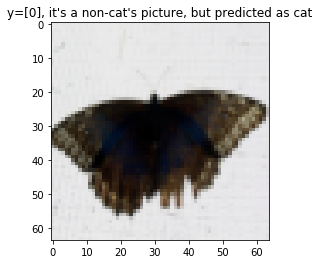

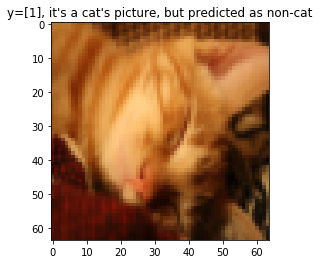

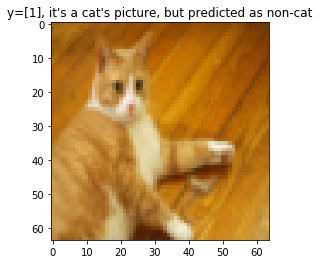

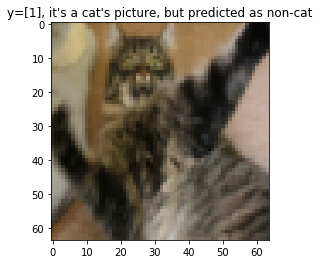

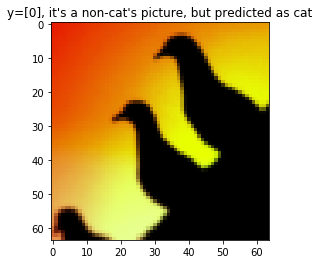

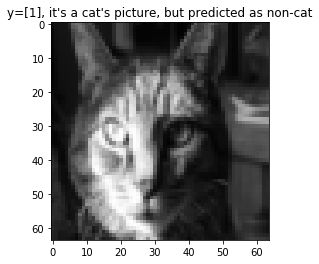

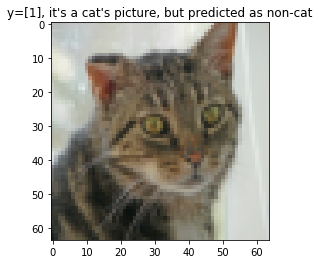

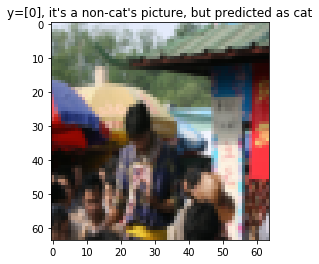

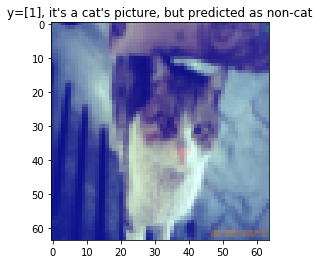

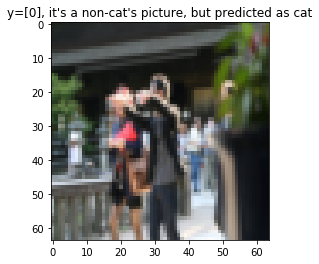

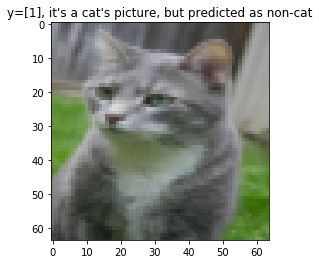

In [18]:
# 找到所有的错误标记的图片（预测集和验证集）
idx_wrong_label=np.where(np.squeeze(np.abs(Y_prediction_test-test_set_y)))[0]
for idx in idx_wrong_label:
    plt.imshow(test_set_x_orig[idx])
    plt.title("y={}, it's a {}'s picture, but predicted as {}".format(
        str(test_set_y[:,idx]),
        (classes[np.squeeze(test_set_y[:,idx])]).decode('utf-8'),
        (classes[np.squeeze(Y_prediction_test[:,idx])]).decode('utf-8')))
    plt.show()


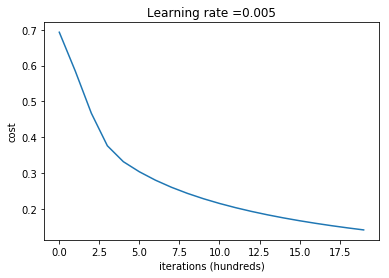

In [22]:
# 绘制 cost 曲线
costs=np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

In [23]:
# 探索不同的学习率与损失函数之间的关系
learning_rates=[0.01,0.001,0.0001]
models={}
for i in learning_rates:
    print("learning_rates={}".format(i))
    models[i]=model(train_set_x,train_set_y,test_set_x,test_set_y,num_iterations=2000,learning_rate=i,print_cost=True)
    print('\n','-'*30)

learning_rates=0.01
cost after 0 iterations, cost=0.6931471805599453
cost after 100 iterations, cost=0.8239208681636133
cost after 200 iterations, cost=0.41894453411731436
cost after 300 iterations, cost=0.6173497038992669
cost after 400 iterations, cost=0.5221157722481847
cost after 500 iterations, cost=0.3877087490998291
cost after 600 iterations, cost=0.2362544567786059
cost after 700 iterations, cost=0.15422213306642313
cost after 800 iterations, cost=0.13532782831392734
cost after 900 iterations, cost=0.12497148000262366
cost after 1000 iterations, cost=0.11647833125696434
cost after 1100 iterations, cost=0.10919251128224015
cost after 1200 iterations, cost=0.1028044641827231
cost after 1300 iterations, cost=0.0971298100802447
cost after 1400 iterations, cost=0.09204326923689712
cost after 1500 iterations, cost=0.08745251991824653
cost after 1600 iterations, cost=0.08328603053700445
cost after 1700 iterations, cost=0.07948657037884148
cost after 1800 iterations, cost=0.07600734572

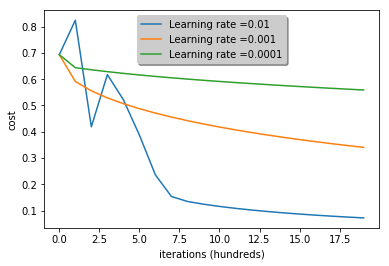

In [29]:
for i in learning_rates:
    plt.plot(np.squeeze(models[i]['costs']),label="Learning rate =" + str(models[i]["learning_rate"]))
plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend=plt.legend(loc='upper center',shadow=True)
frame=legend.get_frame()
frame.set_facecolor('0.8')
plt.show()

/Users/pengju/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Users/pengju/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


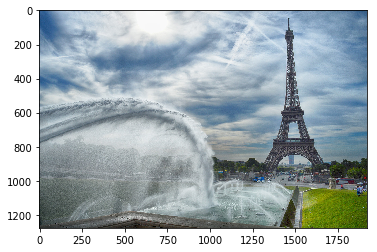

y=0, predicted as non-cat


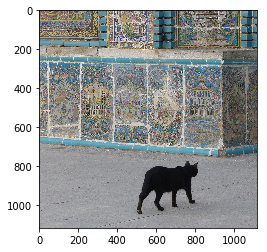

y=1, predicted as cat


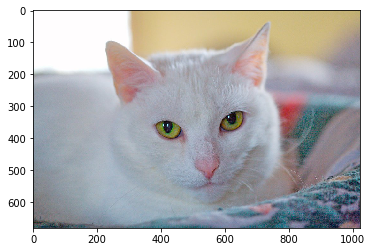

y=1, predicted as cat


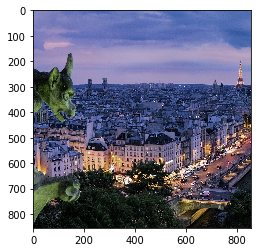

y=1, predicted as cat


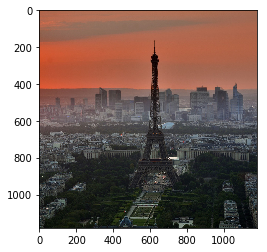

y=1, predicted as cat


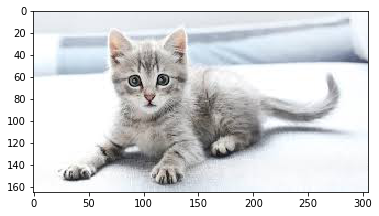

y=1, predicted as cat


In [66]:
# 测试自己的图片
for  my_image in ["LogReg_kiank.png",
"image1.png",
"my_image.jpg",
"cat_in_iran.jpg",
"image2.png",
"my_image2.jpg",
"gargouille.jpg",
"la_defense.jpg",
"my_image3.jpg"]:
    try:        
        fname="images/"+my_image
        image=np.array(ndimage.imread(fname,flatten=False))

        my_image=scipy.misc.imresize(image,size=(num_px,num_px)).reshape((1,num_px*num_px*3)).T
        plt.imshow(image)
        plt.show()
        my_predicted_image= predict(d['w'],d['b'],my_image)
        print("y={}, predicted as {}".format(
            str(np.squeeze(my_predicted_image)),
            classes[(np.squeeze(my_predicted_image))].decode('utf-8')))
    except:
        pass
